In [37]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [38]:
# 폰트지정
plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 부호 깨짐 지정
plt.rcParams['axes.unicode_minus'] = False

# 숫자가 지수표현식으로 나올 때 지정
pd.options.display.float_format = '{:.2f}'.format

In [39]:
# 데이터 로드
file_path = "dataset/seoul_pm10.csv"  # 데이터 파일 경로
df = pd.read_csv(file_path, encoding='cp949')

In [40]:
print("데이터 크기:", df.shape)
print("\n처음 5개 행:")
display(df.head())

데이터 크기: (227759, 4)

처음 5개 행:


,date,area,pm10,pm2.5
0,2022-12-31 23:00,강남구,57.00,44.00
1,2022-12-31 23:00,강동구,68.00,55.00
2,2022-12-31 23:00,강북구,59.00,42.00
3,2022-12-31 23:00,강서구,62.00,40.00
4,2022-12-31 23:00,관악구,57.00,38.00


In [41]:
# 기본 데이터 정보 확인
print("\n데이터 기간:", df['date'].min(), "~", df['date'].max())
print("총 관측 수:", len(df))
print("지역 수:", df['area'].nunique())
print("\n결측치 개수:")
display(df.isnull().sum())


데이터 기간: 2022-01-01 0:00 ~ 2022-12-31 9:00
총 관측 수: 227759
지역 수: 26

결측치 개수:


date        0
area        0
pm10     4916
pm2.5    4247
dtype: int64

In [42]:
# 데이터 전처리
# 날짜 변환
df['date'] = pd.to_datetime(df['date'])

In [43]:
# 결측치 처리
df['pm10'] = df['pm10'].fillna(df['pm10'].mean())
df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

In [44]:
# 시간 관련 피처 추가
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month

In [45]:
# 지역 원-핫 인코딩
df_encoded = pd.get_dummies(df, columns=['area'], prefix='area')

In [46]:
# 전처리된 데이터 확인
print("\n전처리된 데이터 샘플:")
display(df_encoded.head())


전처리된 데이터 샘플:


,date,pm10,pm2.5,hour,day_of_week,month,area_강남구,area_강동구,area_강북구,area_강서구,area_관악구,area_광진구,area_구로구,area_금천구,area_노원구,area_도봉구,area_동대문구,area_동작구,area_마포구,area_서대문구,area_서초구,area_성동구,area_성북구,area_송파구,area_양천구,area_영등포구,area_용산구,area_은평구,area_종로구,area_중구,area_중랑구,area_평균
0,2022-12-31 23:00:00,57.00,44.00,23,5,12,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,2022-12-31 23:00:00,68.00,55.00,23,5,12,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,2022-12-31 23:00:00,59.00,42.00,23,5,12,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,2022-12-31 23:00:00,62.00,40.00,23,5,12,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,2022-12-31 23:00:00,57.00,38.00,23,5,12,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


In [47]:
# PM10 모델 학습
features_pm10 = ['pm2.5', 'hour', 'day_of_week', 'month'] + [col for col in df_encoded.columns if col.startswith('area_')]
X_pm10 = df_encoded[features_pm10]
y_pm10 = df_encoded['pm10']

In [48]:
# PM2.5 모델 학습
features_pm25 = ['pm10', 'hour', 'day_of_week', 'month'] + [col for col in df_encoded.columns if col.startswith('area_')]
X_pm25 = df_encoded[features_pm25]
y_pm25 = df_encoded['pm2.5']

In [49]:
# 데이터 분할
X_train_pm10, X_test_pm10, y_train_pm10, y_test_pm10 = train_test_split(X_pm10, y_pm10, test_size=0.2, random_state=42)
X_train_pm25, X_test_pm25, y_train_pm25, y_test_pm25 = train_test_split(X_pm25, y_pm25, test_size=0.2, random_state=42)

In [51]:
# 모델 학습
model_pm10 = LinearRegression()
model_pm25 = LinearRegression()

In [52]:
model_pm10.fit(X_train_pm10, y_train_pm10)
model_pm25.fit(X_train_pm25, y_train_pm25)

LinearRegression()

In [53]:
# 모델 평가
y_pred_pm10 = model_pm10.predict(X_test_pm10)
y_pred_pm25 = model_pm25.predict(X_test_pm25)

In [54]:
print("\nPM10 모델 성능:")
print(f"R² Score: {r2_score(y_test_pm10, y_pred_pm10):.4f}")
print(f"MSE: {mean_squared_error(y_test_pm10, y_pred_pm10):.4f}")


PM10 모델 성능:
R² Score: 0.6079
MSE: 198.3575


In [55]:
print("\nPM2.5 모델 성능:")
print(f"R² Score: {r2_score(y_test_pm25, y_pred_pm25):.4f}")
print(f"MSE: {mean_squared_error(y_test_pm25, y_pred_pm25):.4f}")


PM2.5 모델 성능:
R² Score: 0.6136
MSE: 73.9499


In [59]:
# 2023년 1월 1일 예측을 위한 함수
def create_prediction_data(area):
    predictions = []
    for hour in range(24):
        pred_data = {
            'hour': hour,
            'day_of_week': 6,  # 2023년 1월 1일은 일요일
            'month': 1
        }

        # 지역 원-핫 인코딩 추가
        for area_col in [col for col in df_encoded.columns if col.startswith('area_')]:
            pred_data[area_col] = 1 if area_col == f'area_{area}' else 0

        predictions.append(pred_data)

    return pd.DataFrame(predictions)

In [60]:
# 사용자 입력 - 지역 선택
areas = sorted(df['area'].unique())
print("\n예측 가능한 지역:")
display(areas)


예측 가능한 지역:


['강남구',
 '강동구',
 '강북구',
 '강서구',
 '관악구',
 '광진구',
 '구로구',
 '금천구',
 '노원구',
 '도봉구',
 '동대문구',
 '동작구',
 '마포구',
 '서대문구',
 '서초구',
 '성동구',
 '성북구',
 '송파구',
 '양천구',
 '영등포구',
 '용산구',
 '은평구',
 '종로구',
 '중구',
 '중랑구',
 '평균']

In [61]:
# 예시로 한 지역 선택 (실제로는 사용자가 선택)
selected_area = areas[0]  # 첫 번째 지역 선택
print(f"\n선택된 지역: {selected_area}")


선택된 지역: 강남구


In [62]:
# 2023년 1월 1일 예측
future_data = create_prediction_data(selected_area)
pm10_predictions = []
pm25_predictions = []

In [63]:
# 반복 예측 (PM10과 PM2.5 상호 의존성 처리)
for hour in range(24):
    hour_data = future_data.iloc[[hour]].copy()

    # 초기값 설정
    hour_data['pm2.5'] = df['pm2.5'].mean()
    hour_data['pm10'] = df['pm10'].mean()

    # 반복 예측으로 정확도 향상
    for _ in range(3):
        pm10_pred = model_pm10.predict(hour_data[features_pm10])
        pm25_pred = model_pm25.predict(hour_data[features_pm25])

        hour_data['pm10'] = pm10_pred
        hour_data['pm2.5'] = pm25_pred

    pm10_predictions.append(pm10_pred[0])
    pm25_predictions.append(pm25_pred[0])

In [64]:
# 예측 결과 시각화
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

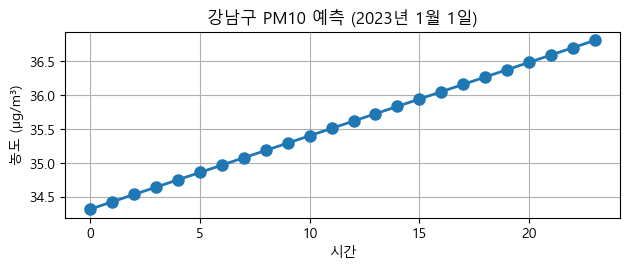

In [65]:
# PM10 그래프
plt.subplot(2, 1, 1)
plt.plot(range(24), pm10_predictions, marker='o', linewidth=2, markersize=8)
plt.title(f'{selected_area} PM10 예측 (2023년 1월 1일)')
plt.xlabel('시간')
plt.ylabel('농도 (μg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

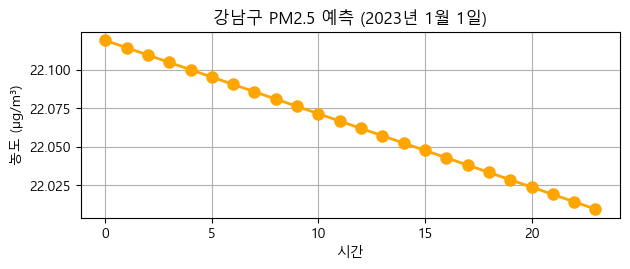

In [66]:
# PM2.5 그래프
plt.subplot(2, 1, 2)
plt.plot(range(24), pm25_predictions, marker='o', linewidth=2, markersize=8, color='orange')
plt.title(f'{selected_area} PM2.5 예측 (2023년 1월 1일)')
plt.xlabel('시간')
plt.ylabel('농도 (μg/m³)')
plt.grid(True)
plt.tight_layout()
plt.show()

In [67]:
# 예측 결과 통계
print("\nPM10 예측 통계:")
print(f"평균: {np.mean(pm10_predictions):.1f} μg/m³")
print(f"최대: {np.max(pm10_predictions):.1f} μg/m³")
print(f"최소: {np.min(pm10_predictions):.1f} μg/m³")


PM10 예측 통계:
평균: 35.6 μg/m³
최대: 36.8 μg/m³
최소: 34.3 μg/m³


In [68]:
print("\nPM2.5 예측 통계:")
print(f"평균: {np.mean(pm25_predictions):.1f} μg/m³")
print(f"최대: {np.max(pm25_predictions):.1f} μg/m³")
print(f"최소: {np.min(pm25_predictions):.1f} μg/m³")


PM2.5 예측 통계:
평균: 22.1 μg/m³
최대: 22.1 μg/m³
최소: 22.0 μg/m³


In [70]:
print("\n시간별 예측값:")# 시간별 예측값 데이터프레임 생성
hourly_predictions = pd.DataFrame({
    '시간': range(24),
    'PM10': [f"{x:.1f}" for x in pm10_predictions],
    'PM2.5': [f"{x:.1f}" for x in pm25_predictions]
})
display(hourly_predictions)


시간별 예측값:


,시간,PM10,PM2.5
0,0,34.3,22.1
1,1,34.4,22.1
2,2,34.5,22.1
3,3,34.6,22.1
4,4,34.8,22.1
5,5,34.9,22.1
6,6,35.0,22.1
7,7,35.1,22.1
8,8,35.2,22.1
9,9,35.3,22.1


In [71]:
print("\n시간별 예측값:")
display(hourly_predictions)


시간별 예측값:


,시간,PM10,PM2.5
0,0,34.3,22.1
1,1,34.4,22.1
2,2,34.5,22.1
3,3,34.6,22.1
4,4,34.8,22.1
5,5,34.9,22.1
6,6,35.0,22.1
7,7,35.1,22.1
8,8,35.2,22.1
9,9,35.3,22.1


In [72]:
# 실제값과 예측값 비교 시각화 (테스트 데이터 기준)
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

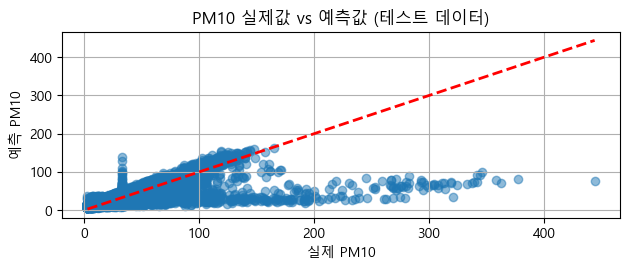

In [73]:
# PM10 비교
plt.subplot(2, 1, 1)
plt.scatter(y_test_pm10, y_pred_pm10, alpha=0.5)
plt.plot([y_test_pm10.min(), y_test_pm10.max()],
         [y_test_pm10.min(), y_test_pm10.max()],
         'r--', lw=2)
plt.xlabel('실제 PM10')
plt.ylabel('예측 PM10')
plt.title('PM10 실제값 vs 예측값 (테스트 데이터)')
plt.grid(True)
plt.tight_layout()
plt.show()

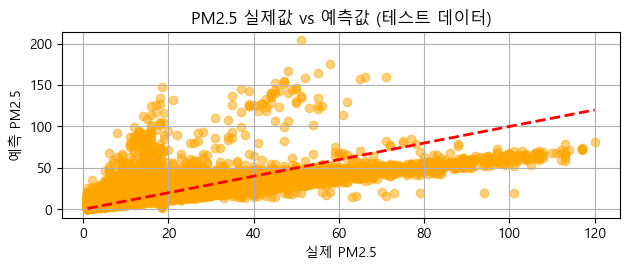

In [74]:
# PM2.5 비교
plt.subplot(2, 1, 2)
plt.scatter(y_test_pm25, y_pred_pm25, alpha=0.5, color='orange')
plt.plot([y_test_pm25.min(), y_test_pm25.max()],
         [y_test_pm25.min(), y_test_pm25.max()],
         'r--', lw=2)
plt.xlabel('실제 PM2.5')
plt.ylabel('예측 PM2.5')
plt.title('PM2.5 실제값 vs 예측값 (테스트 데이터)')
plt.grid(True)
plt.tight_layout()
plt.show()

## 직원 퇴사예측 예제

In [2]:
# 컬럼 설명 : satisfaction_level(직원만족도점수), last_evaluation(고용주평가점수), numbers_projects(할당된 프로젝트수)
# average_monthly_hours(한달동안 직원이 일한 평균시간), time_spent_company(회사에서 근무한 연수), work_accident(근무중 사고유무무)
# promotion_last_5years(지난 5년 직원이 승진했는지 여부), Departments(부서), Salary(월급수준 낮음, 중간, 높음), left(직원퇴사 여부부)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [3]:
# 데이터 로드
df = pd.read_csv('dataset/HR_comma_sep.csv', encoding='cp949')

In [4]:
# 데이터 확인
df.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,Departments,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
# 'left' 열이 정수형인지 확인하고 필요시 변환
if df['left'].dtype != 'int64':
    df['left'] = df['left'].astype(int)

In [10]:
# 'left' 열이 정수형인지 확인하고 필요시 변환
if df['left'].dtype != 'int64':
    df['left'] = df['left'].astype(int)

In [11]:
# 범주형 변수 확인 및 전처리
# 'Departments ' 끝에 공백 제거
df.rename(columns={'Departments ': 'Departments'}, inplace=True)

In [12]:
# 원-핫 인코딩 (범주형 변수 처리)
df = pd.get_dummies(df, columns=['Departments', 'salary'], drop_first=True)

In [13]:
# 독립 변수(X)와 종속 변수(y) 설정
X = df.drop('left', axis=1)
y = df['left']

In [14]:
# 데이터 분할 (Train: 80%, Test: 20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# 데이터 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [16]:
# 모델 학습 - 랜덤 포레스트
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestClassifier(random_state=42)

In [17]:
# 예측
y_pred = model.predict(X_test_scaled)

In [18]:
# 평가
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.99

Confusion Matrix:
[[2286    8]
 [  27  679]]

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2294
           1       0.99      0.96      0.97       706

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.98      3000
weighted avg       0.99      0.99      0.99      3000



In [21]:
# Feature Importance (중요 변수 확인)
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

In [20]:
print("\nFeature Importances:")
print(feature_importances)


Feature Importances:
                    Feature  Importance
0        satisfaction_level    0.331520
2            number_project    0.185824
4        time_spend_company    0.182296
3      average_montly_hours    0.135035
1           last_evaluation    0.123753
5             Work_accident    0.010806
16               salary_low    0.006761
15    Departments_technical    0.003848
17            salary_medium    0.003561
13        Departments_sales    0.003197
14      Departments_support    0.002637
7         Departments_RandD    0.001790
8    Departments_accounting    0.001700
6     promotion_last_5years    0.001605
9            Departments_hr    0.001597
10   Departments_management    0.001526
11    Departments_marketing    0.001321
12  Departments_product_mng    0.001225


## 꽃 이미지 분류 및 예측 예제(CNN)

In [17]:
# flower_photo 디렉토리 밑에 daisy, dandelion, roses, sunflowers, tulips 디렉토리 존재, 약 3670개 사진
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
from tensorflow.keras import layers
import os
import pathlib
import urllib.request
import tarfile

In [18]:
# 데이터 다운로드 함수
def download_and_extract_data():
    # 데이터 URL
    dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

    # 다운로드할 디렉토리 생성
    download_dir = os.path.join(os.getcwd(), 'flower_dataset')
    os.makedirs(download_dir, exist_ok=True)

    # 파일 다운로드
    tgz_path = os.path.join(download_dir, "flower_photos.tgz")

    if not os.path.exists(tgz_path):
        print("데이터셋 다운로드 중...")
        urllib.request.urlretrieve(dataset_url, tgz_path)
        print("다운로드 완료!")

    # 압축 해제
    if not os.path.exists(os.path.join(download_dir, "flower_photos")):
        print("압축 해제 중...")
        with tarfile.open(tgz_path) as tar:
            tar.extractall(path=download_dir)
        print("압축 해제 완료!")

    return os.path.join(download_dir, "flower_photos")

In [19]:
# 데이터 다운로드 및 경로 설정
data_dir = download_and_extract_data()
data_dir = pathlib.Path(data_dir)

In [20]:
# 클래스 및 이미지 개수 확인
classes = sorted([item.name for item in data_dir.glob('*/') if item.is_dir()])
image_count = len(list(data_dir.glob('*/*.jpg')))
print(f"발견된 클래스: {classes}")
print(f"총 이미지 개수: {image_count}")

발견된 클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
총 이미지 개수: 3670


In [21]:
# 각 클래스별 이미지 개수 확인
for class_name in classes:
    class_images = len(list(data_dir.glob(f'{class_name}/*')))
    print(f"{class_name}: {class_images}개 이미지")

daisy: 633개 이미지
dandelion: 898개 이미지
roses: 641개 이미지
sunflowers: 699개 이미지
tulips: 799개 이미지


In [22]:
# 이미지 크기 및 배치 크기 설정
img_height = 180
img_width = 180
batch_size = 32

In [23]:
# 훈련 데이터셋 생성
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [24]:
# 검증 데이터셋 생성
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    str(data_dir),
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [25]:
# 클래스 이름 확인
class_names = train_ds.class_names
print("클래스:", class_names)
num_classes = len(class_names)

클래스: ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [26]:
# 데이터셋 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [27]:
# 데이터 증강 레이어 정의
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

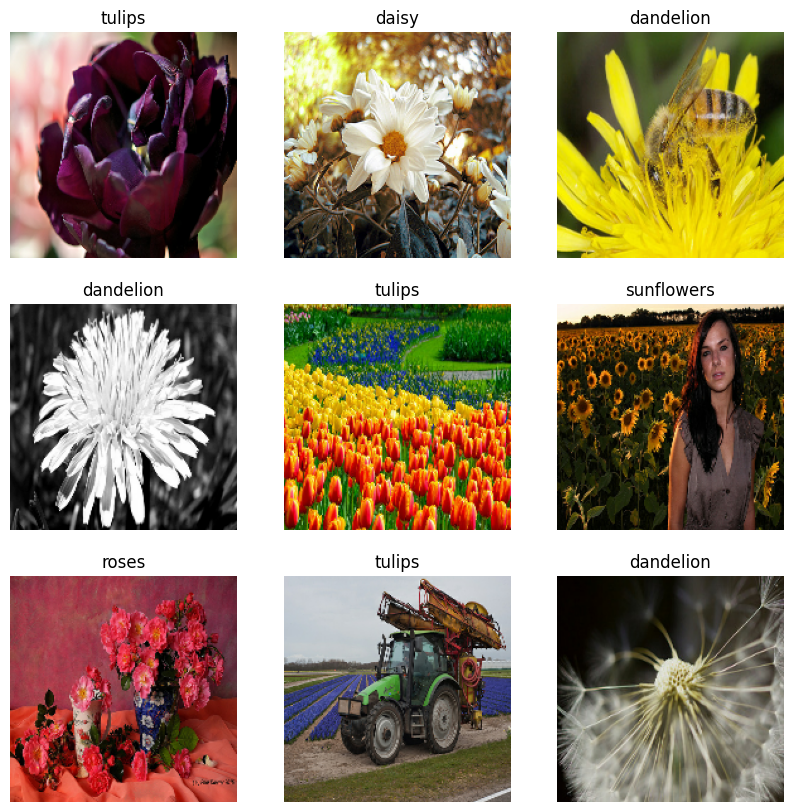

In [28]:
# 샘플 이미지 시각화
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")
plt.show()

In [29]:
# CNN 모델 구성
model = tf.keras.Sequential([
    data_augmentation,
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [30]:
# 모델 컴파일
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [31]:
# 모델 구조 출력
model.summary()

ValueError: This model has not yet been built. Build the model first by calling `build()` or by calling the model on a batch of data.

In [32]:
# Early Stopping 콜백 설정
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True
    )
]

In [33]:
# 모델 학습
epochs = 15
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=callbacks
)

Epoch 1/15
92/92 [==============================] - 72s 768ms/step - loss: 1.3173 - accuracy: 0.4384 - val_loss: 1.1971 - val_accuracy: 0.5204
Epoch 2/15
92/92 [==============================] - 68s 735ms/step - loss: 1.0779 - accuracy: 0.5627 - val_loss: 1.2119 - val_accuracy: 0.5272
Epoch 3/15
92/92 [==============================] - 66s 718ms/step - loss: 0.9880 - accuracy: 0.6056 - val_loss: 0.9187 - val_accuracy: 0.6322
Epoch 4/15
92/92 [==============================] - 62s 675ms/step - loss: 0.9295 - accuracy: 0.6304 - val_loss: 0.9442 - val_accuracy: 0.6213
Epoch 5/15
92/92 [==============================] - 72s 787ms/step - loss: 0.8677 - accuracy: 0.6550 - val_loss: 0.8699 - val_accuracy: 0.6431
Epoch 6/15
92/92 [==============================] - 66s 722ms/step - loss: 0.8305 - accuracy: 0.6856 - val_loss: 0.8039 - val_accuracy: 0.6730
Epoch 7/15
92/92 [==============================] - 66s 724ms/step - loss: 0.7917 - accuracy: 0.6918 - val_loss: 0.9130 - val_accuracy: 0.6567

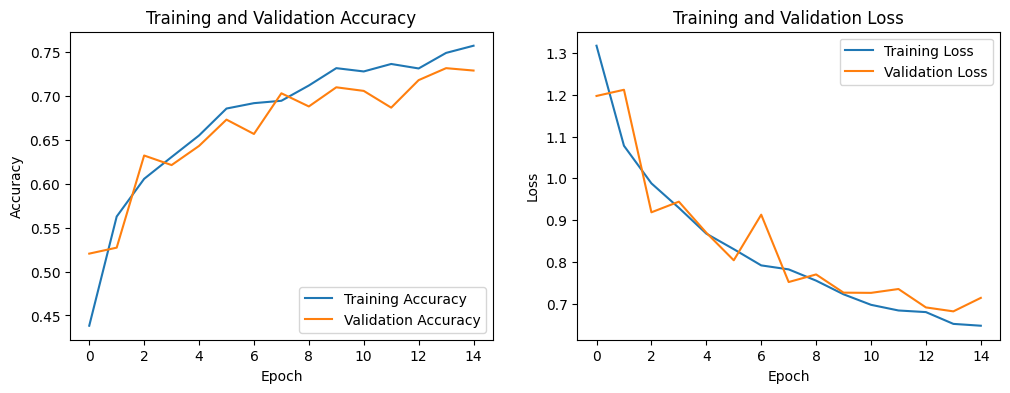

In [34]:
# 학습 결과 시각화
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

In [35]:
# 모델 저장
model.save('./model/flower_classification_model.h5')
print("모델이 'flower_classification_model.h5'로 저장되었습니다.")

모델이 'flower_classification_model.h5'로 저장되었습니다.


In [36]:
# 저장된 모델 불러오기
from tensorflow.keras.models import load_model

In [42]:
model_path = './model/flower_classification_model.h5'  # 저장된 모델 경로
loaded_model = load_model(model_path)
print("저장된 모델이 성공적으로 로드되었습니다.")

저장된 모델이 성공적으로 로드되었습니다.


In [43]:
# 저장된 모델을 활용한 이미지 예측 함수
def predict_flower_with_loaded_model(img_path, model, class_names):
    """
    이미지 경로와 모델을 입력받아 예측 결과를 출력하고 이미지를 시각화하는 함수.

    Parameters:
        img_path (str): 예측할 이미지 파일 경로.
        model (tf.keras.Model): 저장된 모델.
        class_names (list): 클래스 이름 리스트.
    """
    # 이미지 로드 및 전처리
    img = tf.keras.preprocessing.image.load_img(
        img_path, target_size=(img_height, img_width)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # 배치 차원 추가

    # 예측 수행
    predictions = model.predict(img_array)
    score = tf.nn.softmax(predictions[0])

    # 예측 결과 출력
    print(
        "이 이미지는 '{}' ({:.2f}% 확률) 입니다."
        .format(class_names[np.argmax(score)], 100 * np.max(score))
    )

    # 이미지 시각화
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [44]:
# 테스트 이미지 경로
#test_image_path = './flower_dataset/flower_photos/daisy/5547758_eea9edfd54_n.jpg'
test_image_path = './flower_dataset/flower_photos/roses/12240303_80d87f77a3_n.jpg'

이 이미지는 'roses' (34.95% 확률) 입니다.


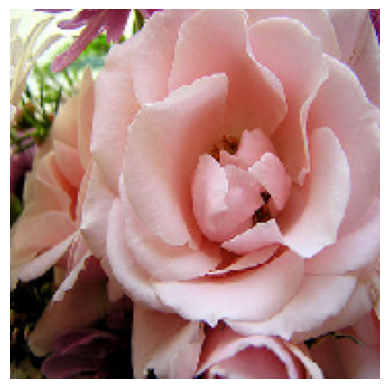

In [45]:
# 예측 실행
predict_flower_with_loaded_model(test_image_path, loaded_model, class_names)

## 클러스터링

In [1]:
import os
os.environ['OMP_NUM_THREADS'] ='1'

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
dataset = pd.read_csv('./dataset/KMeansData.csv')
dataset[:5]

,hour,score
0,7.33,73
1,3.71,55
2,3.43,55
3,3.06,89
4,3.33,79


In [4]:
X = dataset.iloc[:,:].values
X[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

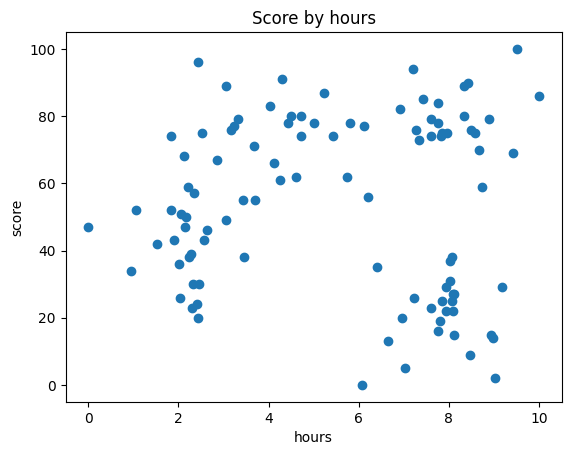

In [7]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

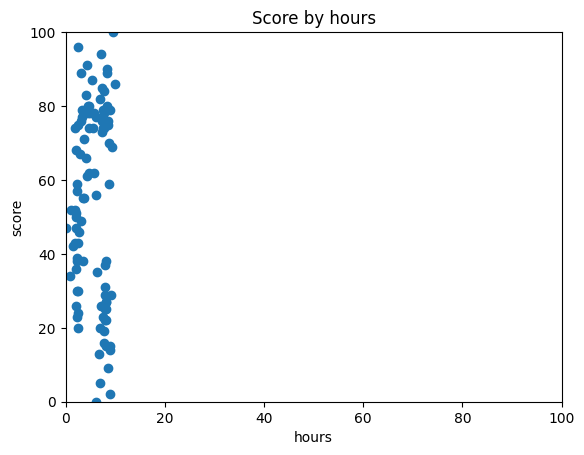

In [6]:
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.xlim(0, 100)
plt.ylabel('score')
plt.ylim(0, 100)
plt.show()

In [8]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)
X[:5]

array([[ 0.68729921,  0.73538376],
       [-0.66687438,  0.04198891],
       [-0.77161709,  0.04198891],
       [-0.9100271 ,  1.35173473],
       [-0.8090252 ,  0.96651537]])

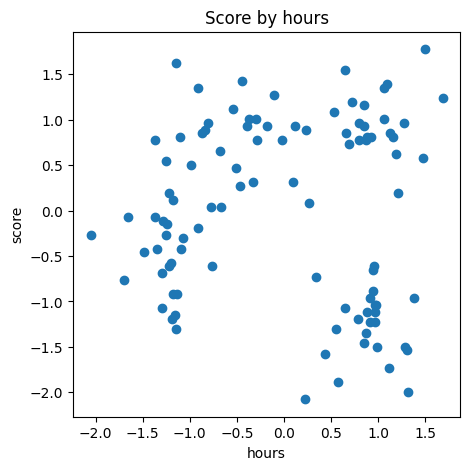

In [9]:
plt.figure(figsize =(5, 5))
plt.scatter(X[:,0], X[:, 1])
plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

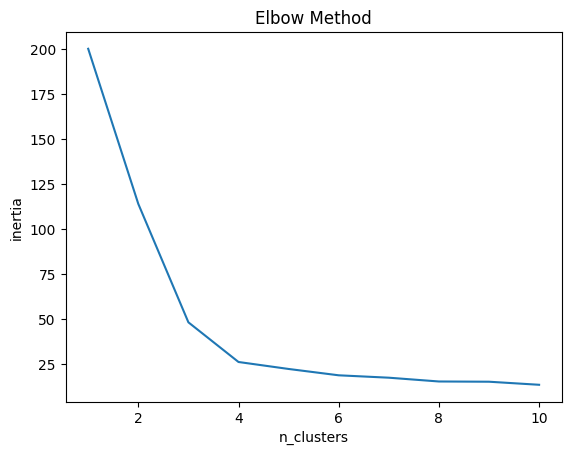

In [10]:
from sklearn.cluster import KMeans
inertia_list = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=0)
    kmeans.fit(X)
    inertia_list.append(kmeans.inertia_)
plt.plot(range(1,11), inertia_list)
plt.title('Elbow Method')
plt.xlabel('n_clusters')
plt.ylabel('inertia')
plt.show()

In [11]:
K=4
kmeans = KMeans(n_clusters=K, random_state=0)
y_kmeans = kmeans.fit_predict(X)

In [12]:
y_kmeans

array([1, 0, 3, 0, 0, 2, 2, 0, 1, 0, 0, 3, 2, 3, 3, 0, 2, 1, 3, 0, 2, 0,
       3, 2, 1, 1, 3, 3, 3, 3, 2, 2, 3, 0, 1, 1, 3, 0, 0, 0, 3, 2, 1, 3,
       3, 1, 2, 0, 2, 2, 1, 0, 2, 2, 0, 0, 0, 0, 3, 2, 2, 1, 1, 1, 1, 2,
       2, 0, 2, 1, 3, 1, 1, 1, 3, 3, 3, 3, 0, 1, 2, 1, 2, 2, 1, 0, 3, 2,
       1, 3, 0, 2, 0, 1, 3, 0, 1, 0, 2, 3])

In [13]:
centers = kmeans.cluster_centers_
centers

array([[-0.54299598,  0.79316666],
       [ 0.96910697,  0.97133061],
       [ 0.8837666 , -1.26929779],
       [-1.24939347, -0.48807293]])

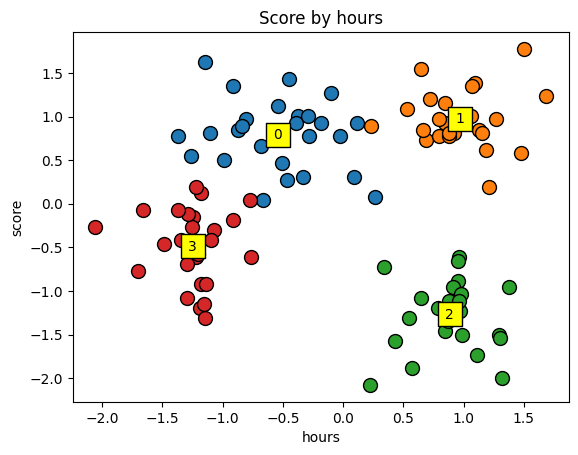

In [15]:
for cluster in range(K):
    plt.scatter(X[y_kmeans == cluster, 0], X[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers[cluster, 0], centers[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers[cluster, 0], centers[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()

In [16]:
X_org = sc.inverse_transform(X)
X_org[:5]

array([[ 7.33, 73.  ],
       [ 3.71, 55.  ],
       [ 3.43, 55.  ],
       [ 3.06, 89.  ],
       [ 3.33, 79.  ]])

In [17]:
centers_org = sc.inverse_transform(centers)
centers_org

array([[ 4.04115385, 74.5       ],
       [ 8.08333333, 79.125     ],
       [ 7.8552    , 20.96      ],
       [ 2.1528    , 41.24      ]])

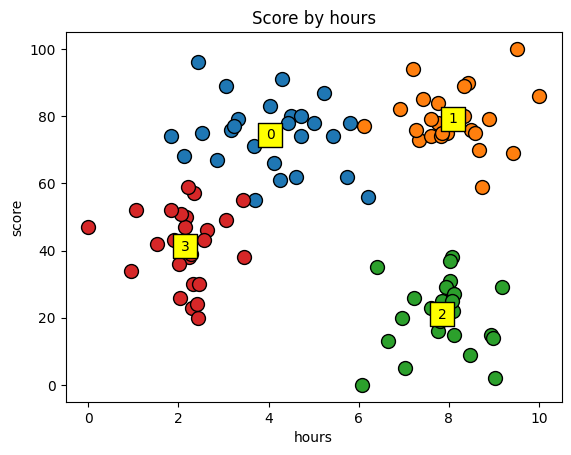

In [18]:
for cluster in range(K):
    plt.scatter(X_org[y_kmeans == cluster, 0], X_org[y_kmeans == cluster, 1], s=100, edgecolor='black')
    plt.scatter(centers_org[cluster, 0], centers_org[cluster, 1], s=300, edgecolor='black', color='yellow', marker='s')
    plt.text(centers_org[cluster, 0], centers_org[cluster, 1], cluster, va='center', ha='center')

plt.title('Score by hours')
plt.xlabel('hours')
plt.ylabel('score')
plt.show()